In [2]:
import sys

sys.path.append('/home/jovyan/work')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd

In [4]:
from helpers.vars import DATA_PATH, RES_PATH
from helpers.analysis import build_windowed_diff_in_diff, replace_outliers_aggdict
from helpers.files import save_did_results, load_interventions
from helpers.retrieval import retrieve_all_editor_activity_levels_for_all_wikis
from helpers.plot import plot_metric_and_did_all_categories

In [5]:
large_wikis = ['en', 'fr', 'de', 'it']
medium_wikis = ['ja', 'sv', 'nl', 'ko']
small_wikis = ['sr', 'no', 'fi', 'da']

In [6]:
agg = pd.read_csv(f'{RES_PATH}/aggregated.tsv.gz', sep='\t')

agg_dict = {}
codes = agg.code.unique()
for c in codes:
    agg_dict[c] = agg[agg.code==c].copy()
    agg_dict[c]['date'] = agg_dict[c]['date'].apply(lambda d: pd.to_datetime(d, format='%Y-%m-%d'))
    agg_dict[c] = agg_dict[c].set_index('date')

In [7]:
interventions = load_interventions(f'{DATA_PATH}/interventions.csv')

In [8]:
# here, count stands for the edit_volume and edit_1 for the newcomers by first edit
agg

date  covid  user_kind  count   rev_len_sum  actor_user  edit_1  \
0      2018-01-01  False    account  71799  1.929916e+09      4178.0  1297.0   
1      2018-01-01  False  anonymous  23740  7.026144e+08         0.0     0.0   
2      2018-01-01  False        bot   7196  1.487072e+08         0.0     0.0   
3      2018-01-01   True    account      4  1.942120e+05      4178.0  1297.0   
4      2018-01-02  False    account  81001  1.992566e+09      5155.0  1905.0   
...           ...    ...        ...    ...           ...         ...     ...   
45917  2020-11-30   True    account      1  1.020430e+05        16.0    12.0   
45918  2020-12-01  False    account    307  3.912818e+06        10.0    12.0   
45919  2020-12-01  False  anonymous    134  1.528426e+06         0.0     0.0   
45920  2020-12-01  False        bot      2  1.804700e+04         0.0     0.0   
45921  2020-12-01   True    account      1  1.112300e+04        10.0    12.0   

       edit_5  revision_is_identity_reverted  revision_is_identity_revert code  
0       348.0                           6011                         6683   en  
1         0.0                           7155                         1083   en  
2         0.0                            257                          627   en  
3       348.0                           6011                         6683   en  
4       485.0                           6355                         7728   en  
...       ...                            ...                          ...  ...  
45917     2.0                              5                           29   da  
45918     2.0                             19                           35   da  
45919     0.0                             44                           11   da  
45920     0.0                              0                            0   da  
45921     2.0                             19                           35   da  

[45922 rows x 11 columns]

# Results

## Edit Volume
The DiD approach is the same for all metrics here. Will comment once between lines. See .py-Files for more details

In [11]:
# remove outliers and build data structure for visualization
ev_dict = replace_outliers_aggdict(agg_dict, 'count', n_std_dev=5, dev_func='mad')
# perform did with outlier removal
pd_dnd_count_95 = build_windowed_diff_in_diff(agg_dict, codes, 'count', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, n_std_outliers=5)
# save did results to csv
save_did_results(pd_dnd_count_95, 'edit_volume')

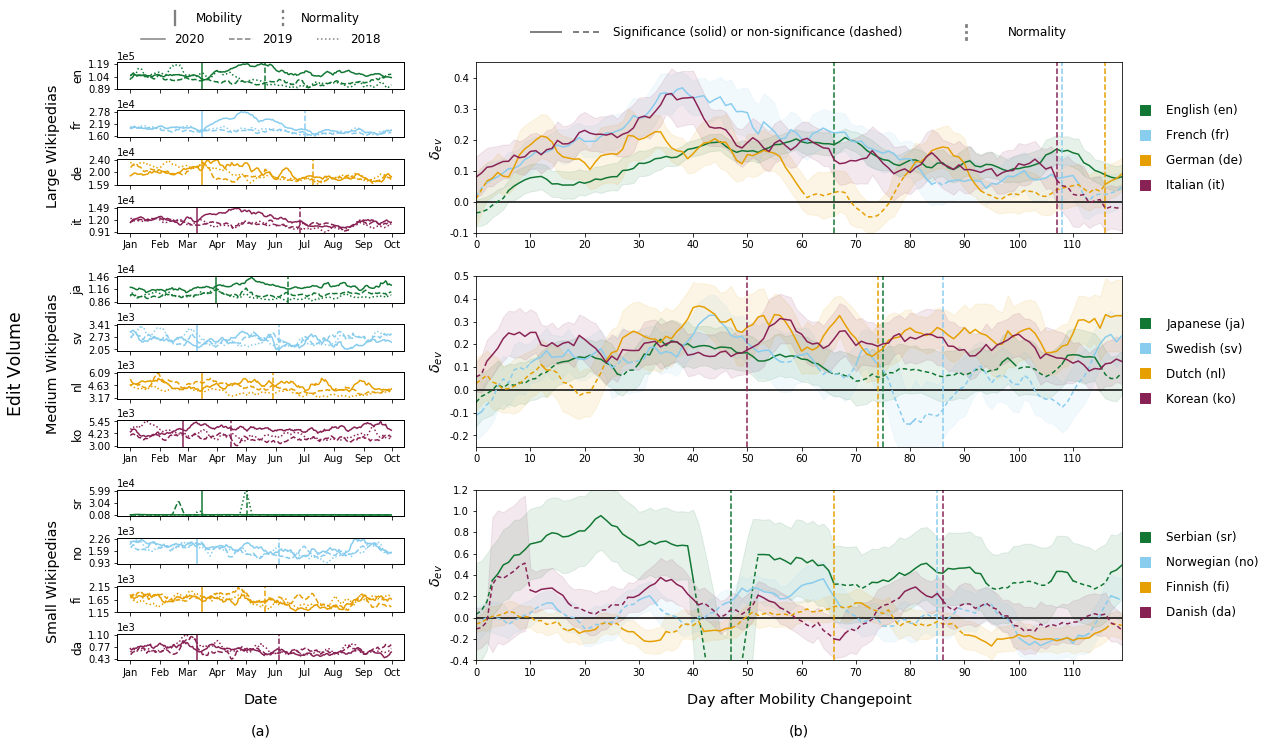

In [12]:
# Visualize
fig_edit = plot_metric_and_did_all_categories(ev_dict, pd_dnd_count_95,
                                        [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Edit Volume', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{ev}$', min_ys=[-0.1, -0.25, -.4], max_ys=[.45, .5, 1.2], figsize=(18, 11))
fig_edit.savefig('../img/comb_ev.pdf', bbox_inches='tight')

## Newcomers

In [13]:
nc_dict = replace_outliers_aggdict(agg_dict, 'edit_1', covid=False, n_std_dev=5, dev_func='mad')
pd_dnd_edit1_95 = build_windowed_diff_in_diff(agg_dict, codes, 'edit_1', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, covid=False, n_std_outliers=5)
save_did_results(pd_dnd_edit1_95, 'newcomers')

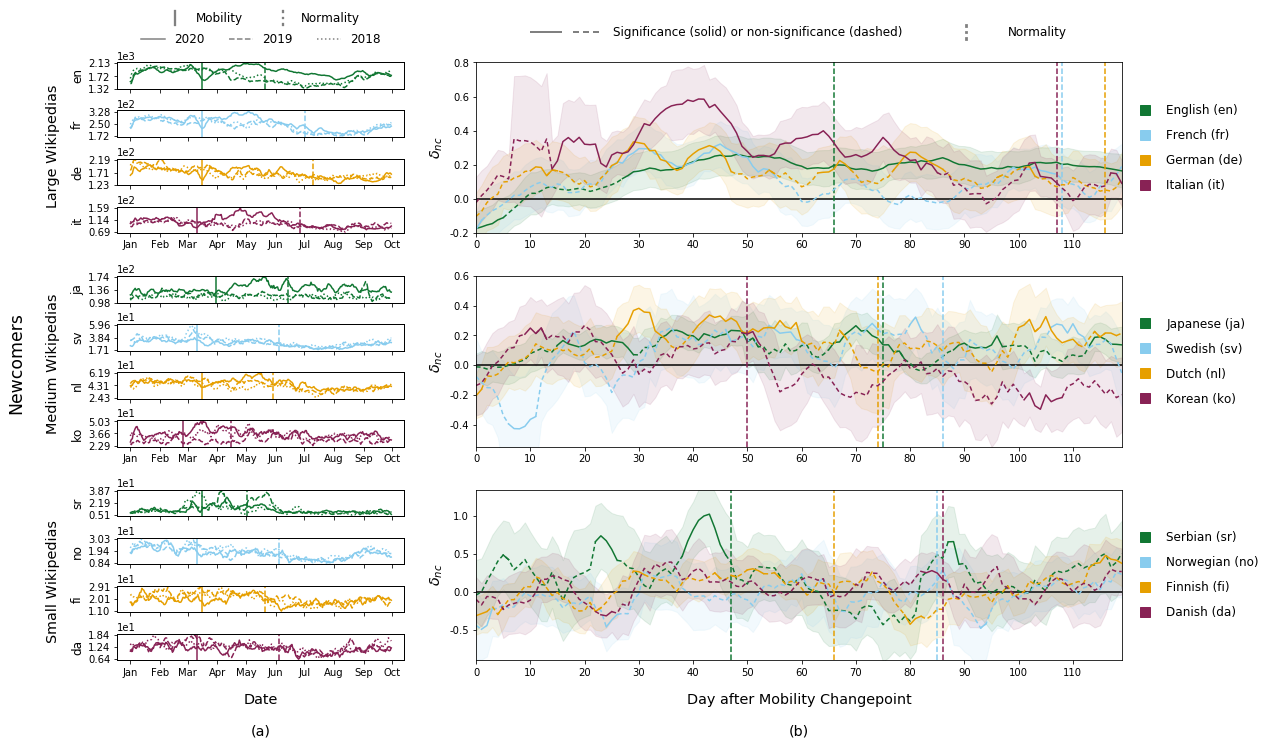

In [14]:
fig = plot_metric_and_did_all_categories(nc_dict, pd_dnd_edit1_95,
                                        [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Newcomers', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{nc}$', min_ys=[-0.2, -0.55, -.9], max_ys=[.8, .6, 1.35], figsize=(18, 11))
fig.savefig('../img/comb_nc.pdf', bbox_inches='tight')

# Discussion

## Revert rate

In [15]:
# compute revert_rate from original dataframe
revert_dict = {}
for code, df_code in agg_dict.items():
    df_code = agg_dict[code].reset_index()
    df_code = df_code[~df_code.covid] # necessary, or otherwise results would be doubled
    revisions_is_revert = df_code[['date', 'revision_is_identity_revert']].groupby('date').sum()
    revisions_is_reverted = df_code[['date', 'revision_is_identity_reverted']].groupby('date').sum()
    daily_nonbot_edits = df_code[df_code.user_kind.isin(['account', 'anonymous'])][['date', 'count']].groupby('date').sum()

    df_complete = daily_nonbot_edits.join(revisions_is_revert).join(revisions_is_reverted)
    df_complete['reverted_rate'] = df_complete['revision_is_identity_reverted'] / df_complete['count']
    df_complete['revert_rate'] = df_complete['revision_is_identity_revert'] / df_complete['count']
    df_complete['user_kind'] = 'account'
    revert_dict[code] = df_complete

In [16]:
rr_dict = replace_outliers_aggdict(revert_dict, 'revert_rate', n_std_dev=5, dev_func='mad')
pd_dnd_rr = build_windowed_diff_in_diff(revert_dict, codes, 'revert_rate', time_int_before=30, time_int_window=7, z_val=2, day_range=120, use_log=True, extra_control=True, n_std_outliers=5)
save_did_results(pd_dnd_rr, 'revert_rate')

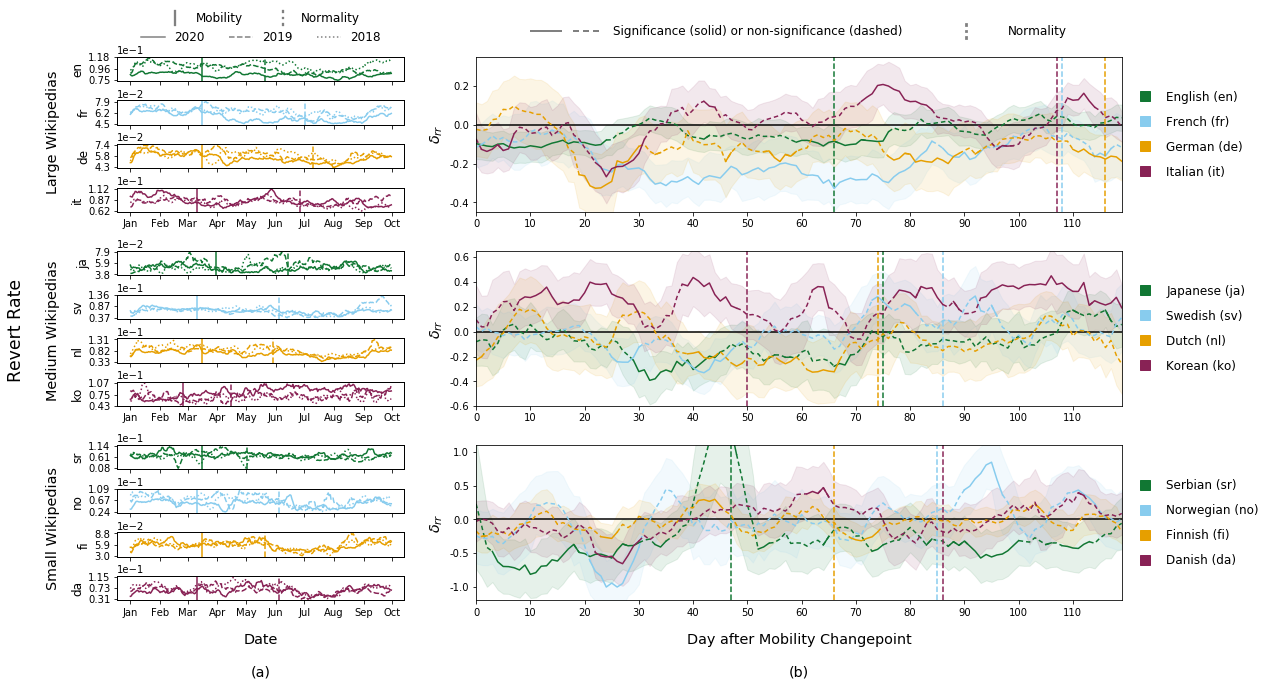

In [17]:
fig = plot_metric_and_did_all_categories(rr_dict, pd_dnd_rr,
                                        [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Revert Rate', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{rr}$', min_ys=[-0.45, -0.6, -1.2], max_ys=[.35, .65, 1.1], figsize=(18, 10))
fig.savefig('../img/comb_rr.pdf', bbox_inches='tight')

## Edit Volume without COVID-19 edits

In [18]:
ev_dict_nocovid = replace_outliers_aggdict(agg_dict, 'count', n_std_dev=5, dev_func='mad', covid=False)
pd_dnd_count_95_nocov = build_windowed_diff_in_diff(agg_dict, codes, 'count', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, covid=False, n_std_outliers=5)
save_did_results(pd_dnd_count_95_nocov, 'edit_volume_nocovid')

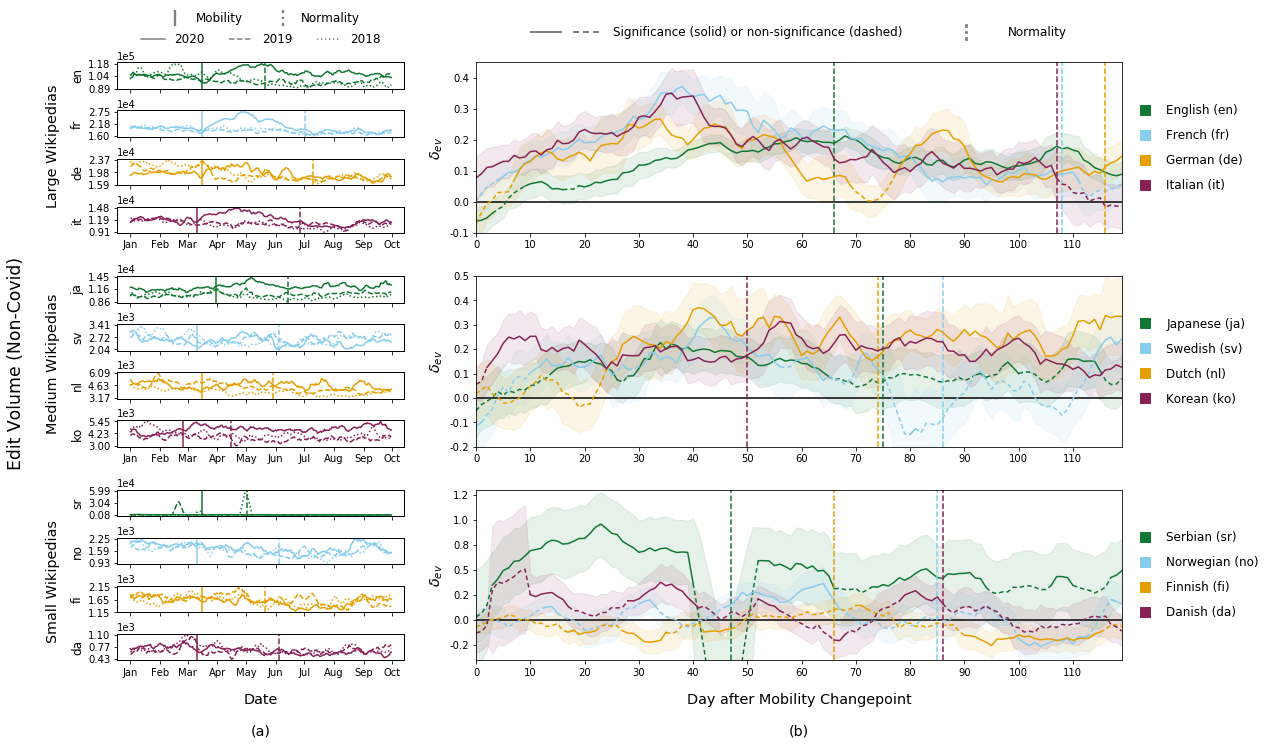

In [19]:
fig = plot_metric_and_did_all_categories(ev_dict_nocovid, pd_dnd_count_95_nocov,
                                          [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Edit Volume (Non-Covid)', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{ev}$', min_ys=[-0.1, -0.2, -0.4], max_ys=[.45, .5, 1.3], figsize=(18, 11))
fig.savefig('../img/comb_ev_nocovid.pdf', bbox_inches='tight')

## Number of editors by activity level

In [20]:
# retrieves active daily editors via wikimedia api
all_activity = retrieve_all_editor_activity_levels_for_all_wikis(codes)

In [21]:
act_dict = {}
codes = all_activity.code.unique()
for c in codes:
    act_dict[c] = all_activity[all_activity.code==c].reset_index()
    act_dict[c]['date'] = act_dict[c]['date'].apply(lambda d: pd.to_datetime(d, format='%Y-%m-%d'))
    act_dict[c] = act_dict[c].set_index('date')
    act_dict[c]['covid'] = False
    act_dict[c]['user_kind'] = 'account'

In [22]:
act_dict['en']

all-activity-levels  1..4-edits  5..24-edits  25..99-edits  \
date                                                                     
2017-12-01                10103        7336         2259           434   
2017-12-02                 9221        6601         2083           473   
2017-12-03                 9650        6855         2226           498   
2017-12-04                10761        7785         2395           499   
2017-12-05                10623        7625         2439           481   
...                         ...         ...          ...           ...   
2020-11-26                10455        7467         2411           501   
2020-11-27                10265        7219         2406           558   
2020-11-28                10178        7027         2516           541   
2020-11-29                10823        7615         2508           616   
2020-11-30                11714        8374         2683           572   

            100..-edits code  covid user_kind  
date                                           
2017-12-01           74   en  False   account  
2017-12-02           64   en  False   account  
2017-12-03           71   en  False   account  
2017-12-04           82   en  False   account  
2017-12-05           78   en  False   account  
...                 ...  ...    ...       ...  
2020-11-26           76   en  False   account  
2020-11-27           82   en  False   account  
2020-11-28           94   en  False   account  
2020-11-29           84   en  False   account  
2020-11-30           85   en  False   account  

[1096 rows x 8 columns]

### 1 to 4 daily edits

In [23]:
dict_1_4 = replace_outliers_aggdict(act_dict, '1..4-edits', n_std_dev=5, dev_func='mad')
did_1_4 = build_windowed_diff_in_diff(act_dict, codes,  '1..4-edits', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, n_std_outliers=5)
save_did_results(did_1_4, 'editors_01to04')

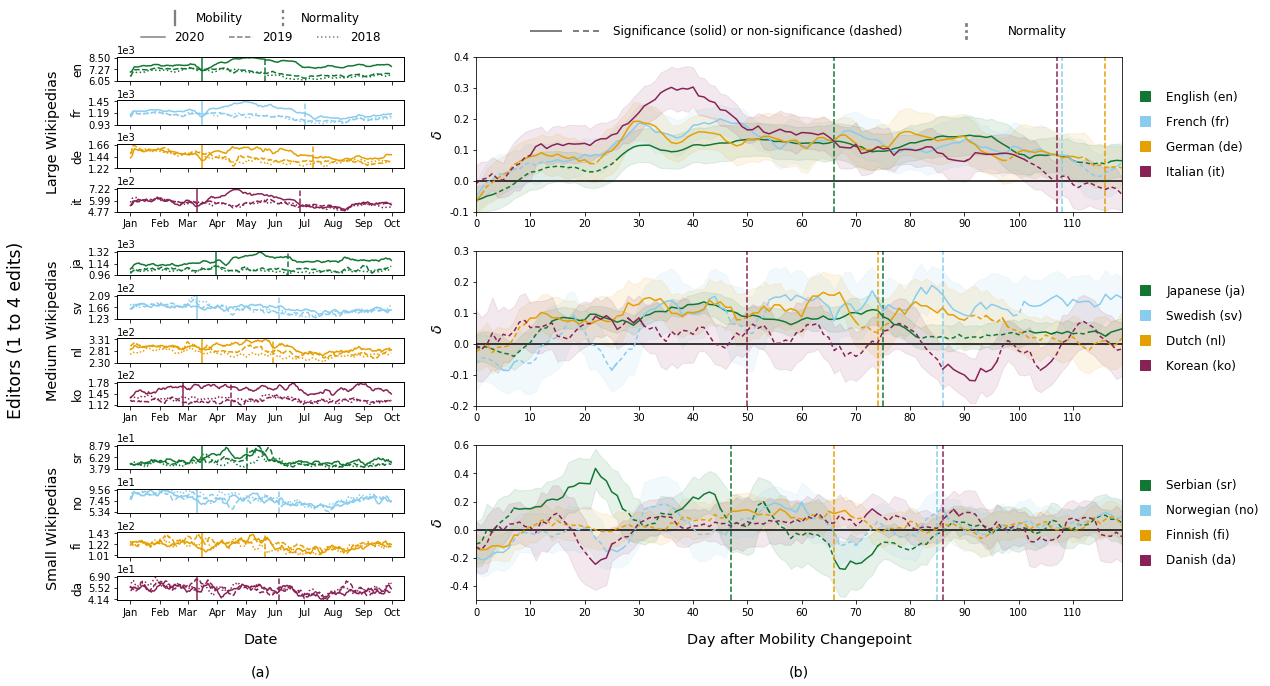

In [24]:
fig_14 = plot_metric_and_did_all_categories(dict_1_4, did_1_4,
                                                [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                                 'Editors (1 to 4 edits)', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                                 interventions=interventions, did_label = r'$\delta$', min_ys=[-0.1, -0.2, -.5], max_ys=[.4, .3, .6], figsize=(18, 10))
fig_14.savefig('../img/did_active_14.pdf', bbox_inches='tight')

### 5 to 24 daily edits

In [25]:
dict_5_24 = replace_outliers_aggdict(act_dict, '5..24-edits', n_std_dev=5, dev_func='mad')
did_5_24 =build_windowed_diff_in_diff(act_dict, codes,  '5..24-edits', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, n_std_outliers=5)
save_did_results(did_5_24, 'editors_05to24')

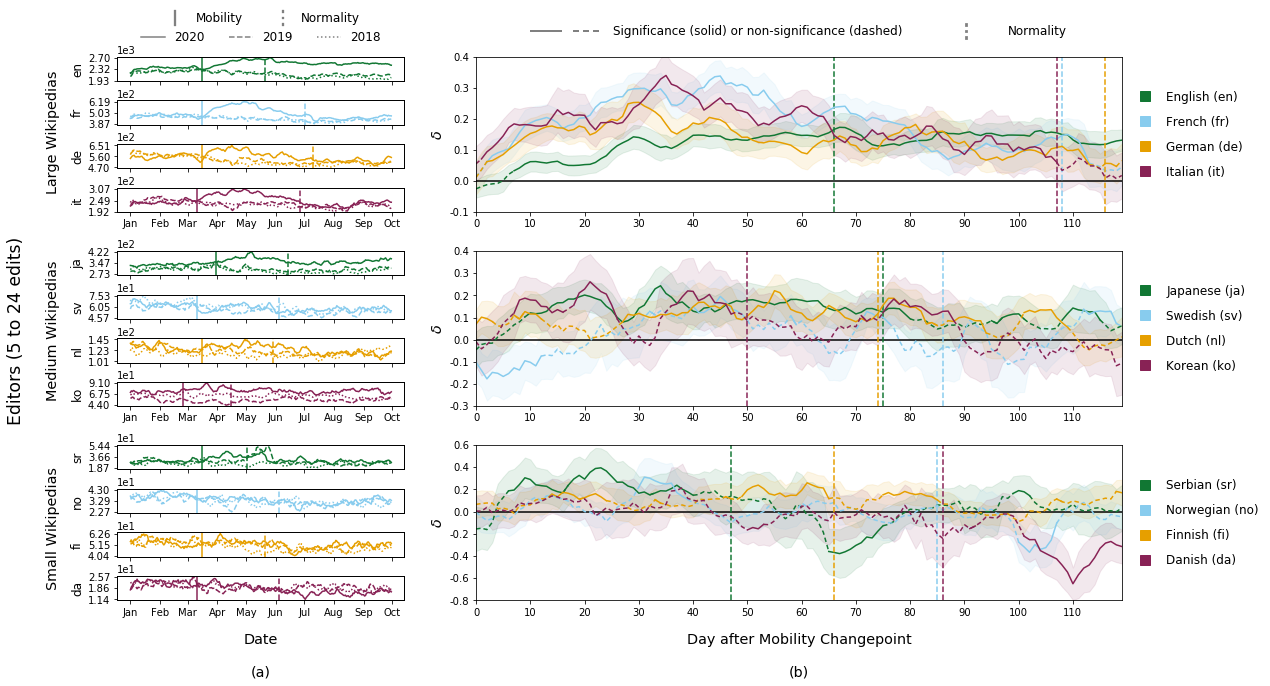

In [26]:
fig_524 = plot_metric_and_did_all_categories(dict_5_24, did_5_24,
                                                [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                                 'Editors (5 to 24 edits)', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                                 interventions=interventions, did_label = r'$\delta$', min_ys=[-0.1, -0.3, -.8], max_ys=[.4, .4, .6], figsize=(18, 10))
fig_524.savefig('../img/did_active_524.pdf', bbox_inches='tight')

### 25 to 99 daily edits

In [27]:
dict_25_99 = replace_outliers_aggdict(act_dict, '25..99-edits', n_std_dev=5, dev_func='mad')
did_25_99 = build_windowed_diff_in_diff(act_dict, codes,  '25..99-edits', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, n_std_outliers=5)
save_did_results(did_25_99, 'editors_25to99')

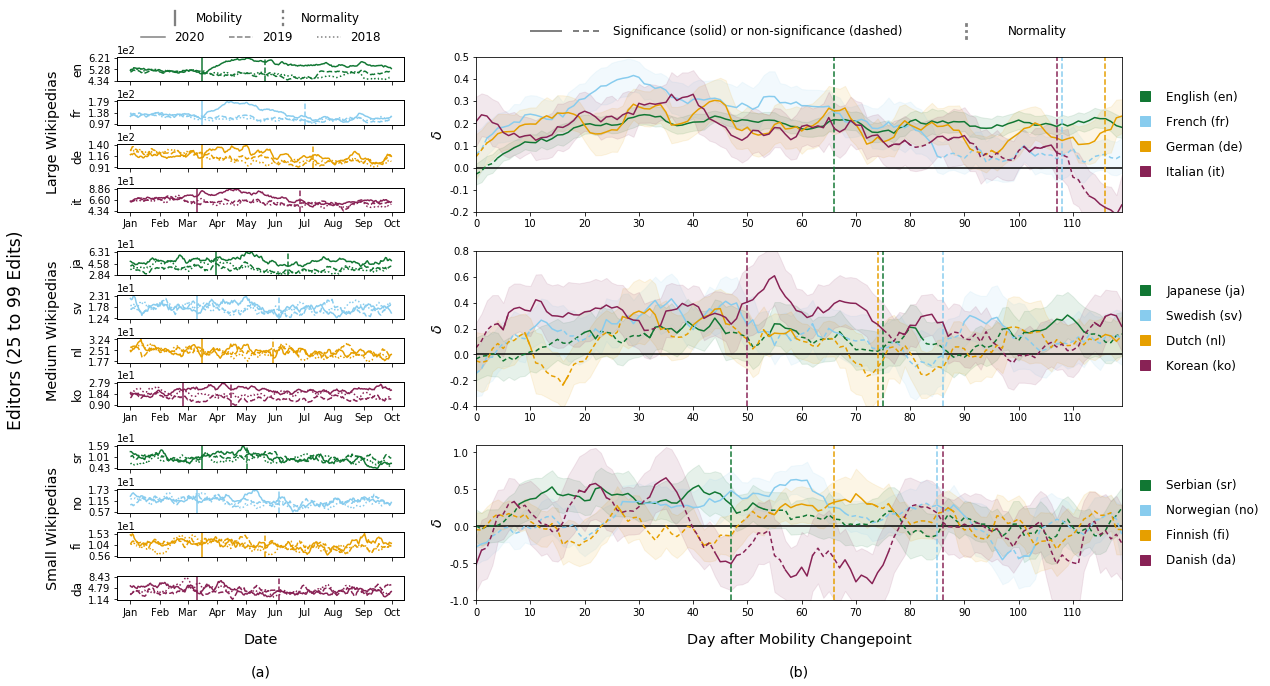

In [28]:
fig_2599 = plot_metric_and_did_all_categories(dict_25_99, did_25_99,
                                                [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                                 'Editors (25 to 99 Edits)', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                                 interventions=interventions, did_label = r'$\delta$', min_ys=[-0.2, -0.4, -1], max_ys=[.5, .8, 1.1], figsize=(18, 10))
fig_2599.savefig('../img/did_active_2599.pdf', bbox_inches='tight')

### More than 99 daily edits

In [29]:
dict_100 = replace_outliers_aggdict(act_dict, '100..-edits', n_std_dev=5, dev_func='mad')
did_100 = build_windowed_diff_in_diff(act_dict, codes,  '100..-edits', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, n_std_outliers=5)
save_did_results(did_100, 'editors_99more')

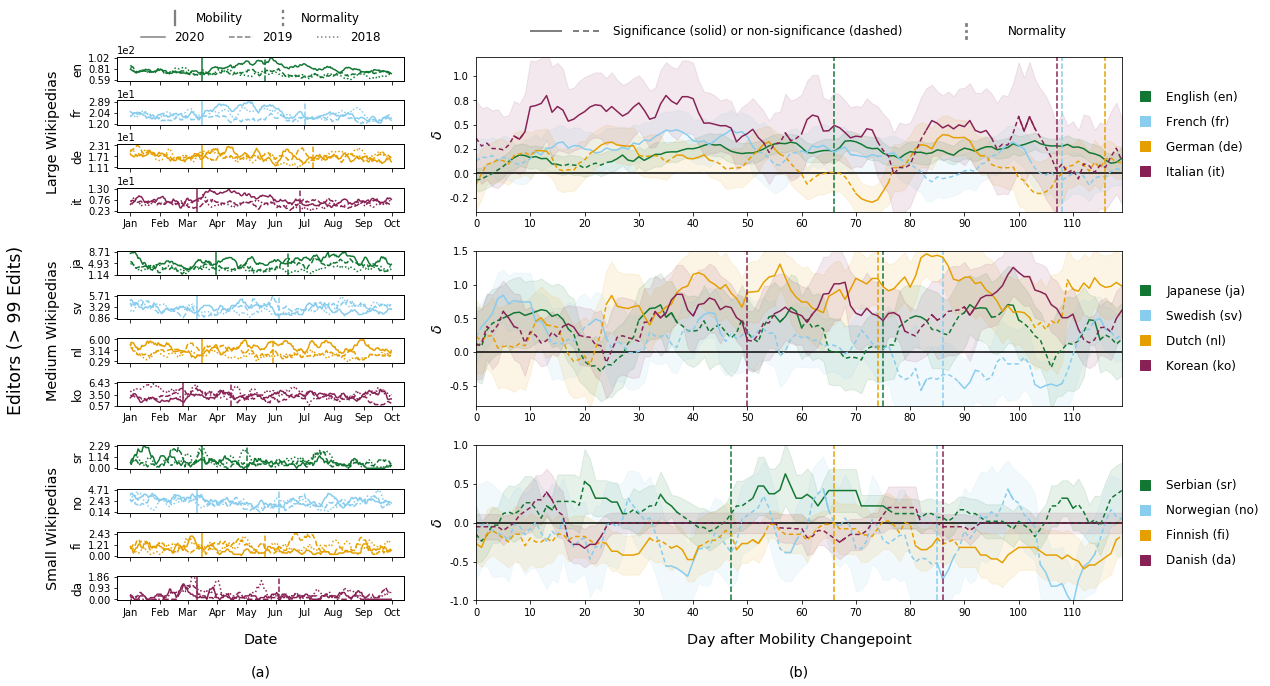

In [30]:
fig_100 = plot_metric_and_did_all_categories(dict_100, did_100,
                                                [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                                 'Editors (> 99 Edits)', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                                 interventions=interventions, did_label = r'$\delta$', min_ys=[-0.4, -0.8, -1], max_ys=[1.2, 1.5, 1], figsize=(18, 10))
fig_100.savefig('../img/did_active_100.pdf', bbox_inches='tight')

# Methods (Robustness checks)

## 14-day window

### Edit Volume

In [31]:
pd_dnd_ev_14 = build_windowed_diff_in_diff(agg_dict, codes, 'count', time_int_before=30, time_int_window=14, z_val=2, day_range=120, extra_control=True, n_std_outliers=5)

In [32]:
save_did_results(pd_dnd_ev_14, 'edit_volume_rob_14d')

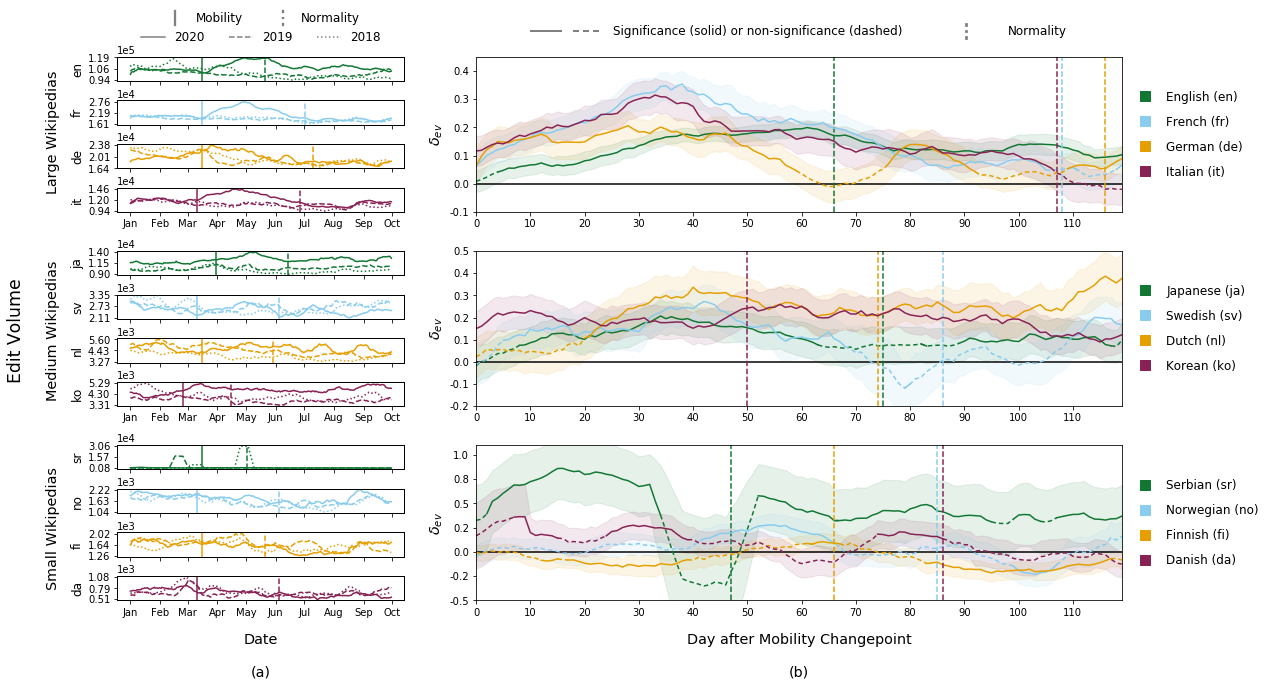

In [33]:
fig_ev = plot_metric_and_did_all_categories(ev_dict, pd_dnd_ev_14,
                                        [lambda code, agg: agg[code].rolling(14, center=True).mean()],
                                         'Edit Volume', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{ev}$', min_ys=[-0.1, -0.2, -.5], max_ys=[.45, .5, 1.1], figsize=(18, 10))
fig_ev.savefig('../img/var_ev_14d.pdf', bbox_inches='tight')

### Newcomers

In [34]:
pd_dnd_nc_14 = build_windowed_diff_in_diff(agg_dict, codes, 'edit_1', time_int_before=30, time_int_window=14, z_val=2, day_range=120, extra_control=True, covid=False, n_std_outliers=5)

In [35]:
save_did_results(pd_dnd_nc_14, 'newcomers_rob_14d')

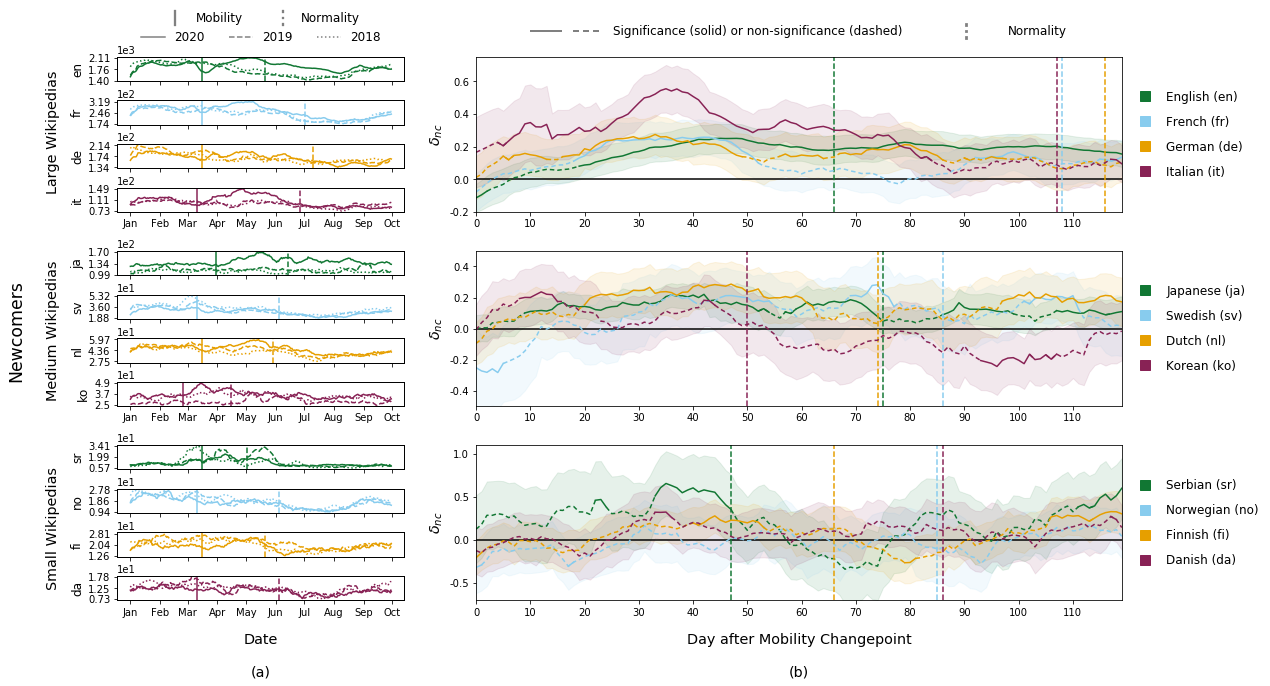

In [36]:
fig_nc = plot_metric_and_did_all_categories(nc_dict, pd_dnd_nc_14,
                                        [lambda code, agg: agg[code].rolling(14, center=True).mean()],
                                         'Newcomers', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{nc}$', min_ys=[-0.2, -.5, -.7], max_ys=[.75, .5, 1.1], figsize=(18, 10))
fig_nc.savefig('../img/var_nc_14d.pdf', bbox_inches='tight')

### Revert rate

In [37]:
pd_dnd_rr_14 = build_windowed_diff_in_diff(revert_dict, codes, 'revert_rate', time_int_before=30, time_int_window=14, z_val=2, day_range=120, use_log=True, extra_control=True, n_std_outliers=5)

In [38]:
save_did_results(pd_dnd_rr_14, 'revert_rate_rob_14d')

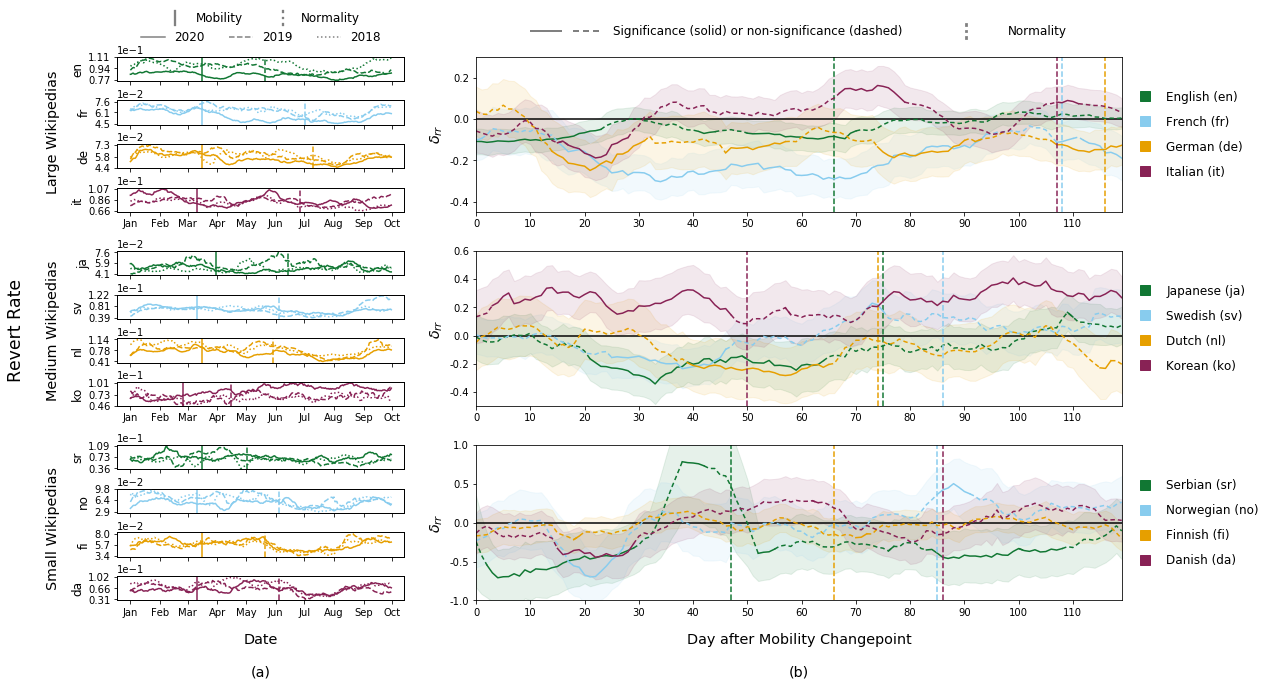

In [39]:
fig_rr = plot_metric_and_did_all_categories(rr_dict, pd_dnd_rr_14,
                                        [lambda code, agg: agg[code].rolling(14, center=True).mean()],
                                         'Revert Rate', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{rr}$', min_ys=[-0.45, -0.5, -1], max_ys=[.3, .6, 1], figsize=(18, 10))
fig_rr.savefig('../img/var_rr_14d.pdf', bbox_inches='tight')

## Changepoint 7 days earlier

### Edit Volume

In [40]:
pd_dnd_ev_m1w = build_windowed_diff_in_diff(agg_dict, codes, 'count', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, n_std_outliers=5, window_delta=-7)
save_did_results(pd_dnd_ev_m1w, 'edit_volume_rob_chp7before')

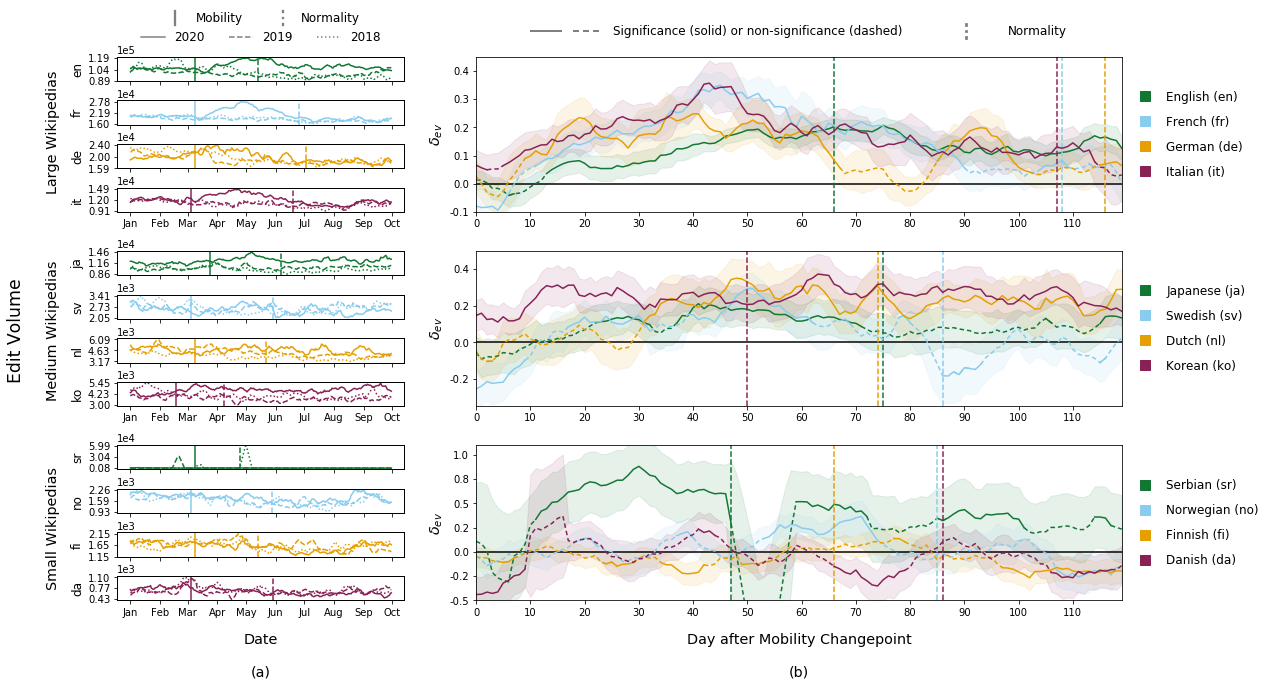

In [53]:
fig_evm1w = plot_metric_and_did_all_categories(ev_dict, pd_dnd_ev_m1w,
                                        [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Edit Volume', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{ev}$', min_ys=[-0.1, -0.35, -.5], max_ys=[.45, .5, 1.1], figsize=(18, 10),
                                        intervention_delta = -7)
fig_evm1w.savefig('../img/var_ev_cp1wbefore.pdf', bbox_inches='tight')

### Newcomers

In [42]:
pd_dnd_nc_m1w = build_windowed_diff_in_diff(agg_dict, codes, 'edit_1', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, covid=False, n_std_outliers=5, window_delta=-7)
save_did_results(pd_dnd_nc_m1w, 'newcomers_rob_chp7before')

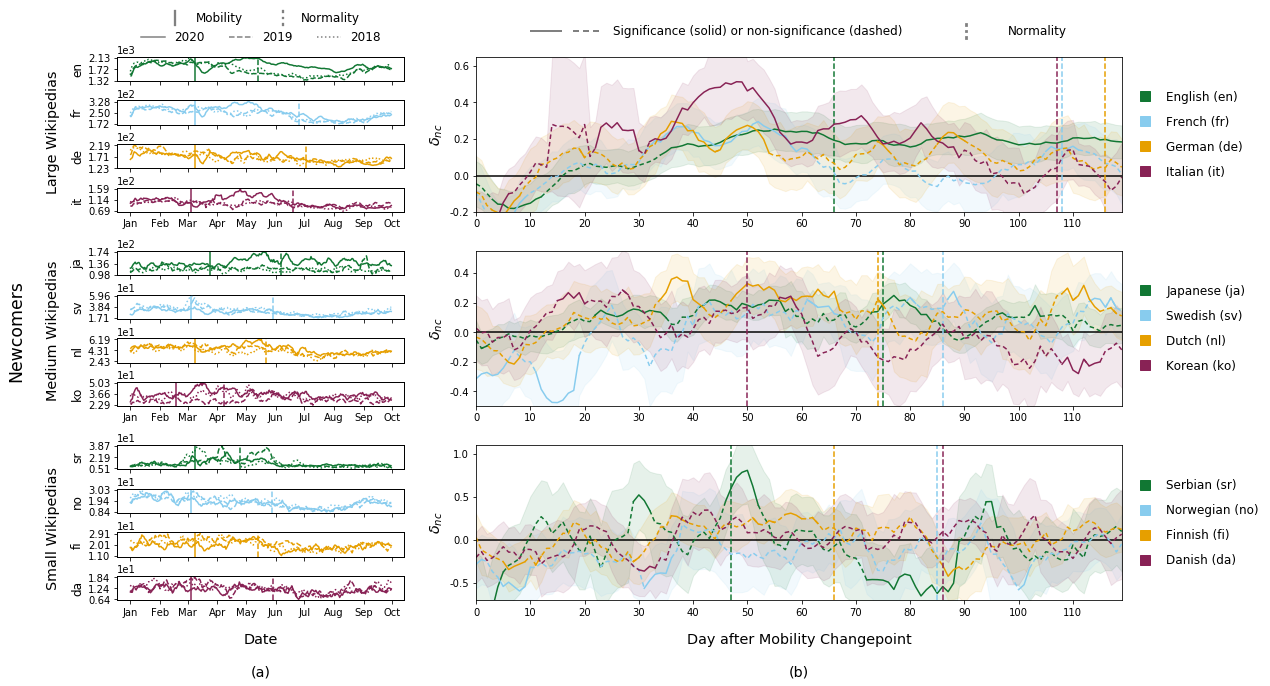

In [54]:
fig_ncm1w = plot_metric_and_did_all_categories(nc_dict, pd_dnd_nc_m1w,
                                        [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Newcomers', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{nc}$', min_ys=[-0.2, -.5, -.7], max_ys=[.65, .55, 1.1], figsize=(18, 10),
                                              intervention_delta = -7)
fig_ncm1w.savefig('../img/var_nc_cp1wbefore.pdf', bbox_inches='tight')

### Revert rate

In [44]:
pd_dnd_rr_m1w = build_windowed_diff_in_diff(revert_dict, codes, 'revert_rate', time_int_before=30, time_int_window=7, z_val=2, day_range=120, use_log=True, extra_control=True, n_std_outliers=5, window_delta=-7)
save_did_results(pd_dnd_rr_m1w, 'revert_rate_rob_chp7before')

In [45]:
save_did_results(pd_dnd_rr_m1w, 'revert_rate_rob_chp7before')

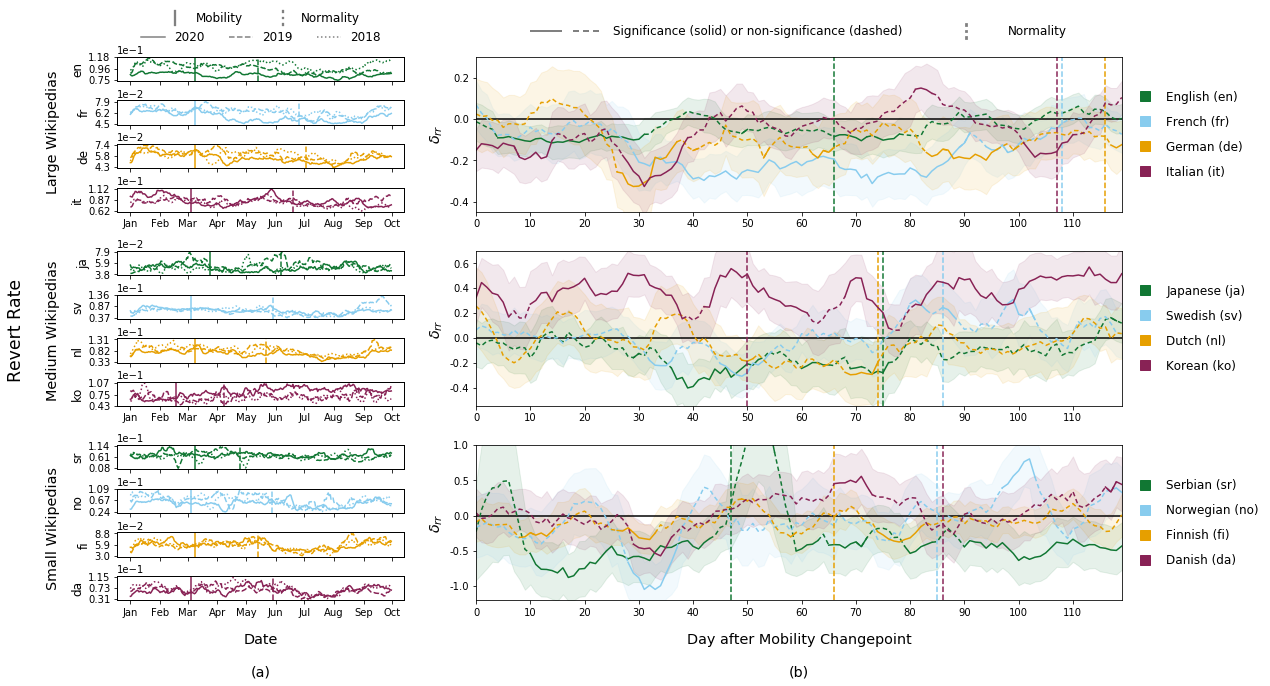

In [55]:
fig_rrm1w = plot_metric_and_did_all_categories(rr_dict, pd_dnd_rr_m1w,
                                        [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Revert Rate', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{rr}$', min_ys=[-0.45, -0.55, -1.2], max_ys=[.3, .7, 1], figsize=(18, 10),
                                              intervention_delta = -7)
fig_rrm1w.savefig('../img/var_rr_cp1wbefore.pdf', bbox_inches='tight')

## Changepoint 7 days later

### Edit Volume

In [47]:
pd_dnd_ev_p1w = build_windowed_diff_in_diff(agg_dict, codes, 'count', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, n_std_outliers=5, window_delta=7)
save_did_results(pd_dnd_ev_p1w, 'edit_volume_rob_chp7after')

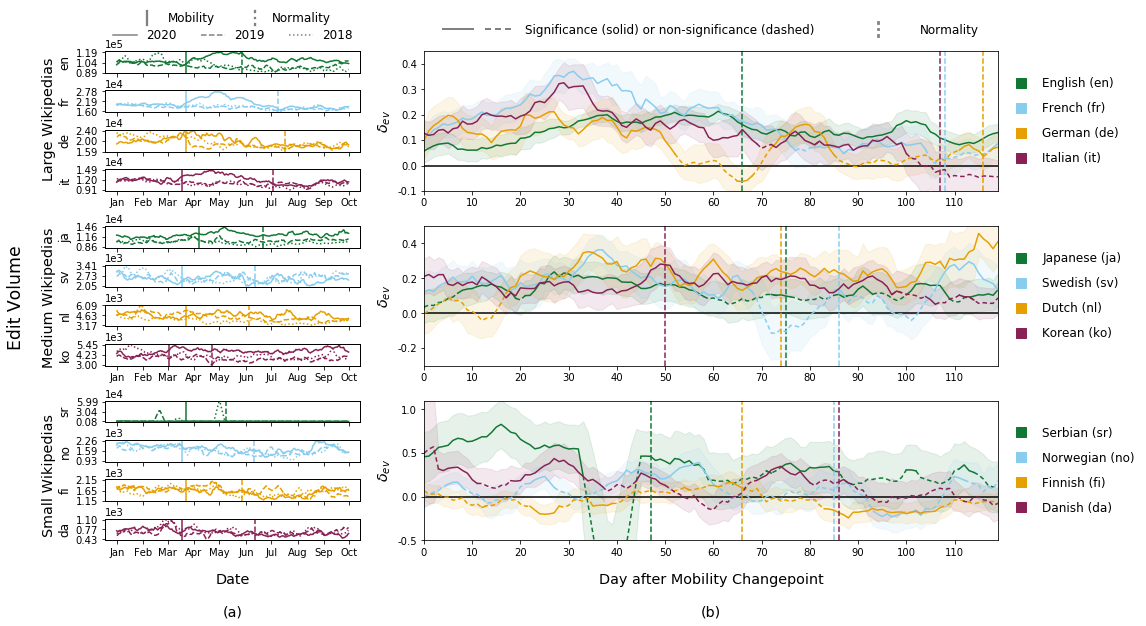

In [56]:
fig_evm1p = plot_metric_and_did_all_categories(ev_dict, pd_dnd_ev_p1w,
                                        [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Edit Volume', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{ev}$', min_ys=[-0.1, -0.3, -.5], max_ys=[.45, .5, 1.1], figsize=(16, 9),
                                              intervention_delta = 7)
fig_evm1p.savefig('../img/var_ev_cp1wafter.pdf', bbox_inches='tight')

### Newcomers

In [49]:
pd_dnd_nc_p1w = build_windowed_diff_in_diff(agg_dict, codes, 'edit_1', time_int_before=30, time_int_window=7, z_val=2, day_range=120, extra_control=True, covid=False, n_std_outliers=5, window_delta=7)
save_did_results(pd_dnd_nc_p1w, 'newcomers_rob_chp7after')

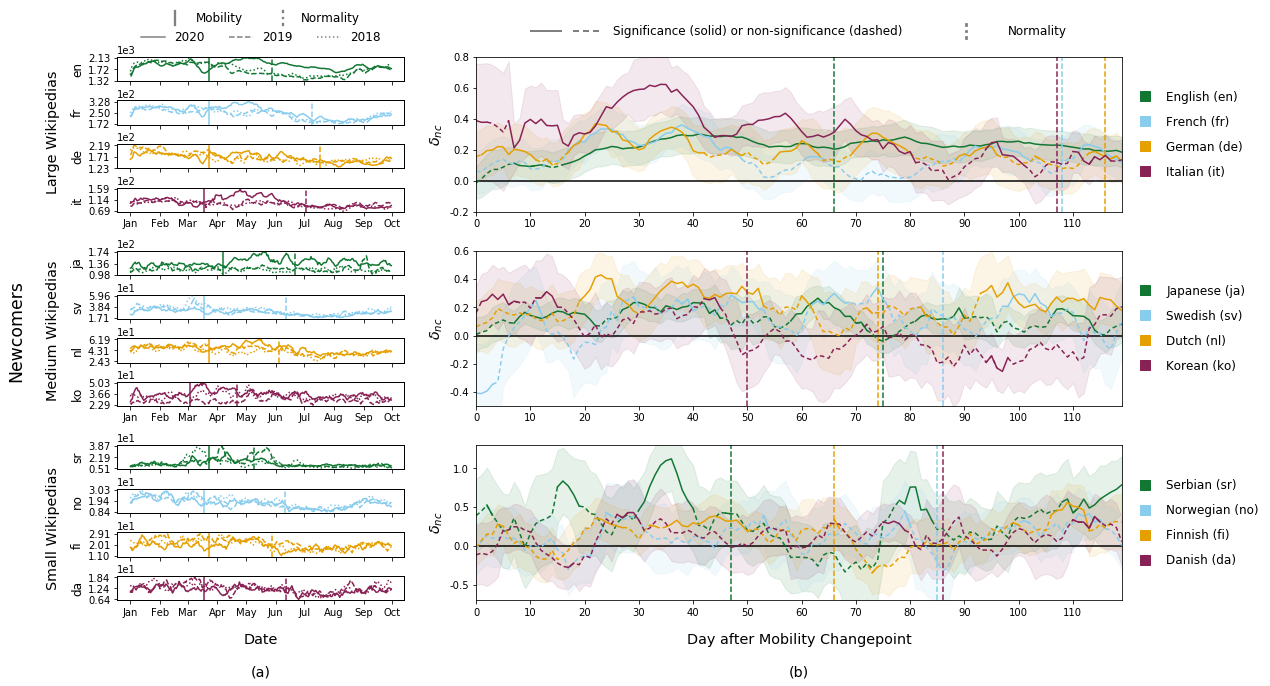

In [57]:
fig_ncm1p = plot_metric_and_did_all_categories(nc_dict, pd_dnd_nc_p1w,
                                        [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                         'Newcomers', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                         interventions=interventions, did_label = r'$\delta_{nc}$', min_ys=[-0.2, -.5, -.7], max_ys=[.8, .6, 1.3], figsize=(18, 10),
                                         intervention_delta = 7)
fig_ncm1p.savefig('../img/var_nc_cp1wafter.pdf', bbox_inches='tight')

### Revert rate

In [51]:
pd_dnd_rr_p1w = build_windowed_diff_in_diff(revert_dict, codes, 'revert_rate', time_int_before=30, time_int_window=7, z_val=2, day_range=120, use_log=True, extra_control=True, n_std_outliers=5, window_delta=7)
save_did_results(pd_dnd_rr_p1w, 'revert_rate_rob_chp7after')

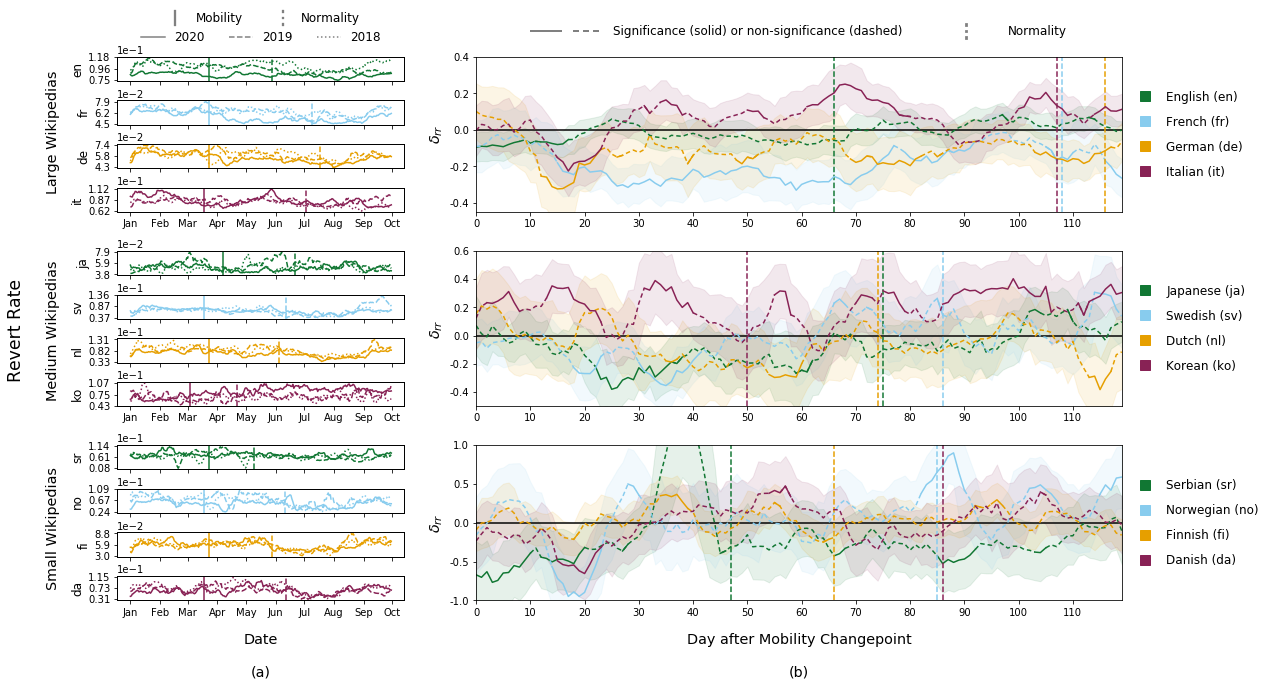

In [58]:
fig_rrm1p = plot_metric_and_did_all_categories(rr_dict, pd_dnd_rr_p1w,
                                                [lambda code, agg: agg[code].rolling(7, center=True).mean()],
                                                 'Revert Rate', [large_wikis, medium_wikis, small_wikis], ['Large Wikipedias', 'Medium Wikipedias', 'Small Wikipedias'],
                                                 interventions=interventions, did_label = r'$\delta_{rr}$', min_ys=[-0.45, -0.5, -1], max_ys=[.4, .6, 1], figsize=(18, 10),
                                                 intervention_delta = 7)
fig_rrm1p.savefig('../img/var_rr_cp1wafter.pdf', bbox_inches='tight')